In [4]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42

In [5]:

dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier_new.h5'

In [6]:
NUM_CLASSES = 10

In [7]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [8]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [9]:
print(len(X_dataset))
print(len(y_dataset))

2560
2560


In [10]:
print(y_dataset)
print(X_dataset.shape)

[0 0 0 ... 9 9 9]
(2560, 42)


In [11]:
train_ratio = 0.80
test_ratio = 0.20

X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=1-train_ratio, random_state=RANDOM_SEED)

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [13]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________


In [16]:
hist=model.fit(X_train,y_train,epochs=500,batch_size=128,validation_data=(X_test, y_test),callbacks=[cp_callback, es_callback])

Epoch 1/500
11/16 [===================>..........] - ETA: 0s - loss: 2.3702 - accuracy: 0.0859 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier_new.h5
16/16 [==============================] - 5s 71ms/step - loss: 2.3517 - accuracy: 0.0903 - val_loss: 2.2694 - val_accuracy: 0.0566
Epoch 2/500
10/16 [=================>............] - ETA: 0s - loss: 2.2776 - accuracy: 0.1289
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier_new.h5
16/16 [==============================] - 0s 23ms/step - loss: 2.2620 - accuracy: 0.1460 - val_loss: 2.1801 - val_accuracy: 0.2539
Epoch 3/500
 9/16 [===============>..............] - ETA: 0s - loss: 2.2075 - accuracy: 0.1832
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier_new.h5
16/16 [==============================] - 0s 17ms/step - loss: 2.1962 - accuracy: 0.1992 - val_loss: 2.0800 - val_accuracy: 0.2559
Epoch 4/500
10/16 [=================>............] - ETA: 0s - loss: 2.1229 - accuracy: 0.

CNN Error: 1.37%


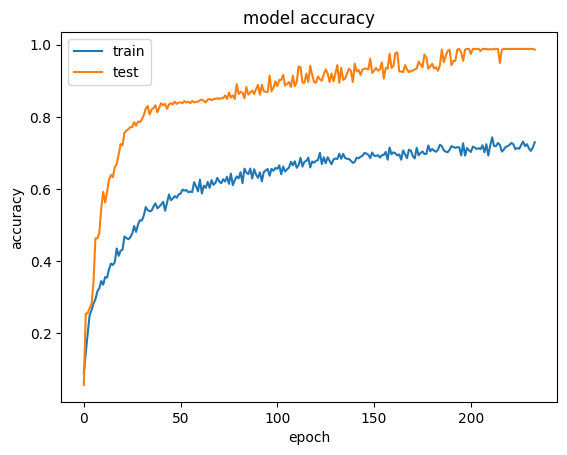

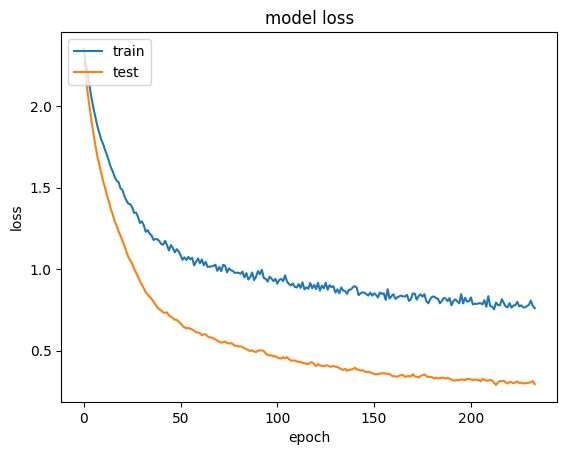

In [17]:
import matplotlib.pyplot as plt
# val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)
scores = model.evaluate(X_test,y_test, verbose=0)
print("CNN Error: %.2f%%" % (100 - scores[1] * 100))
model.save(model_save_path,include_optimizer=False)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_graph.png')
plt.show()
# summarize history for loss

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss_graph.png')
plt.show()

16/16 [==============================] - 0s 3ms/step
Average prediction time: 0.001328s


Classification Report
---------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        67
           1       1.00      1.00      1.00        56
           2       0.98      1.00      0.99        53
           3       0.99      1.00      0.99        68
           4       1.00      1.00      1.00        51
           5       0.97      0.95      0.96        66
           6       1.00      0.97      0.99        37
           7       1.00      0.93      0.96        28
           8       1.00      1.00      1.00        44
           9       1.00      0.98      0.99        42

    accuracy                           0.99       512
   macro avg       0.99      0.98      0.99       512
weighted avg       0.99      0.99      0.99       512



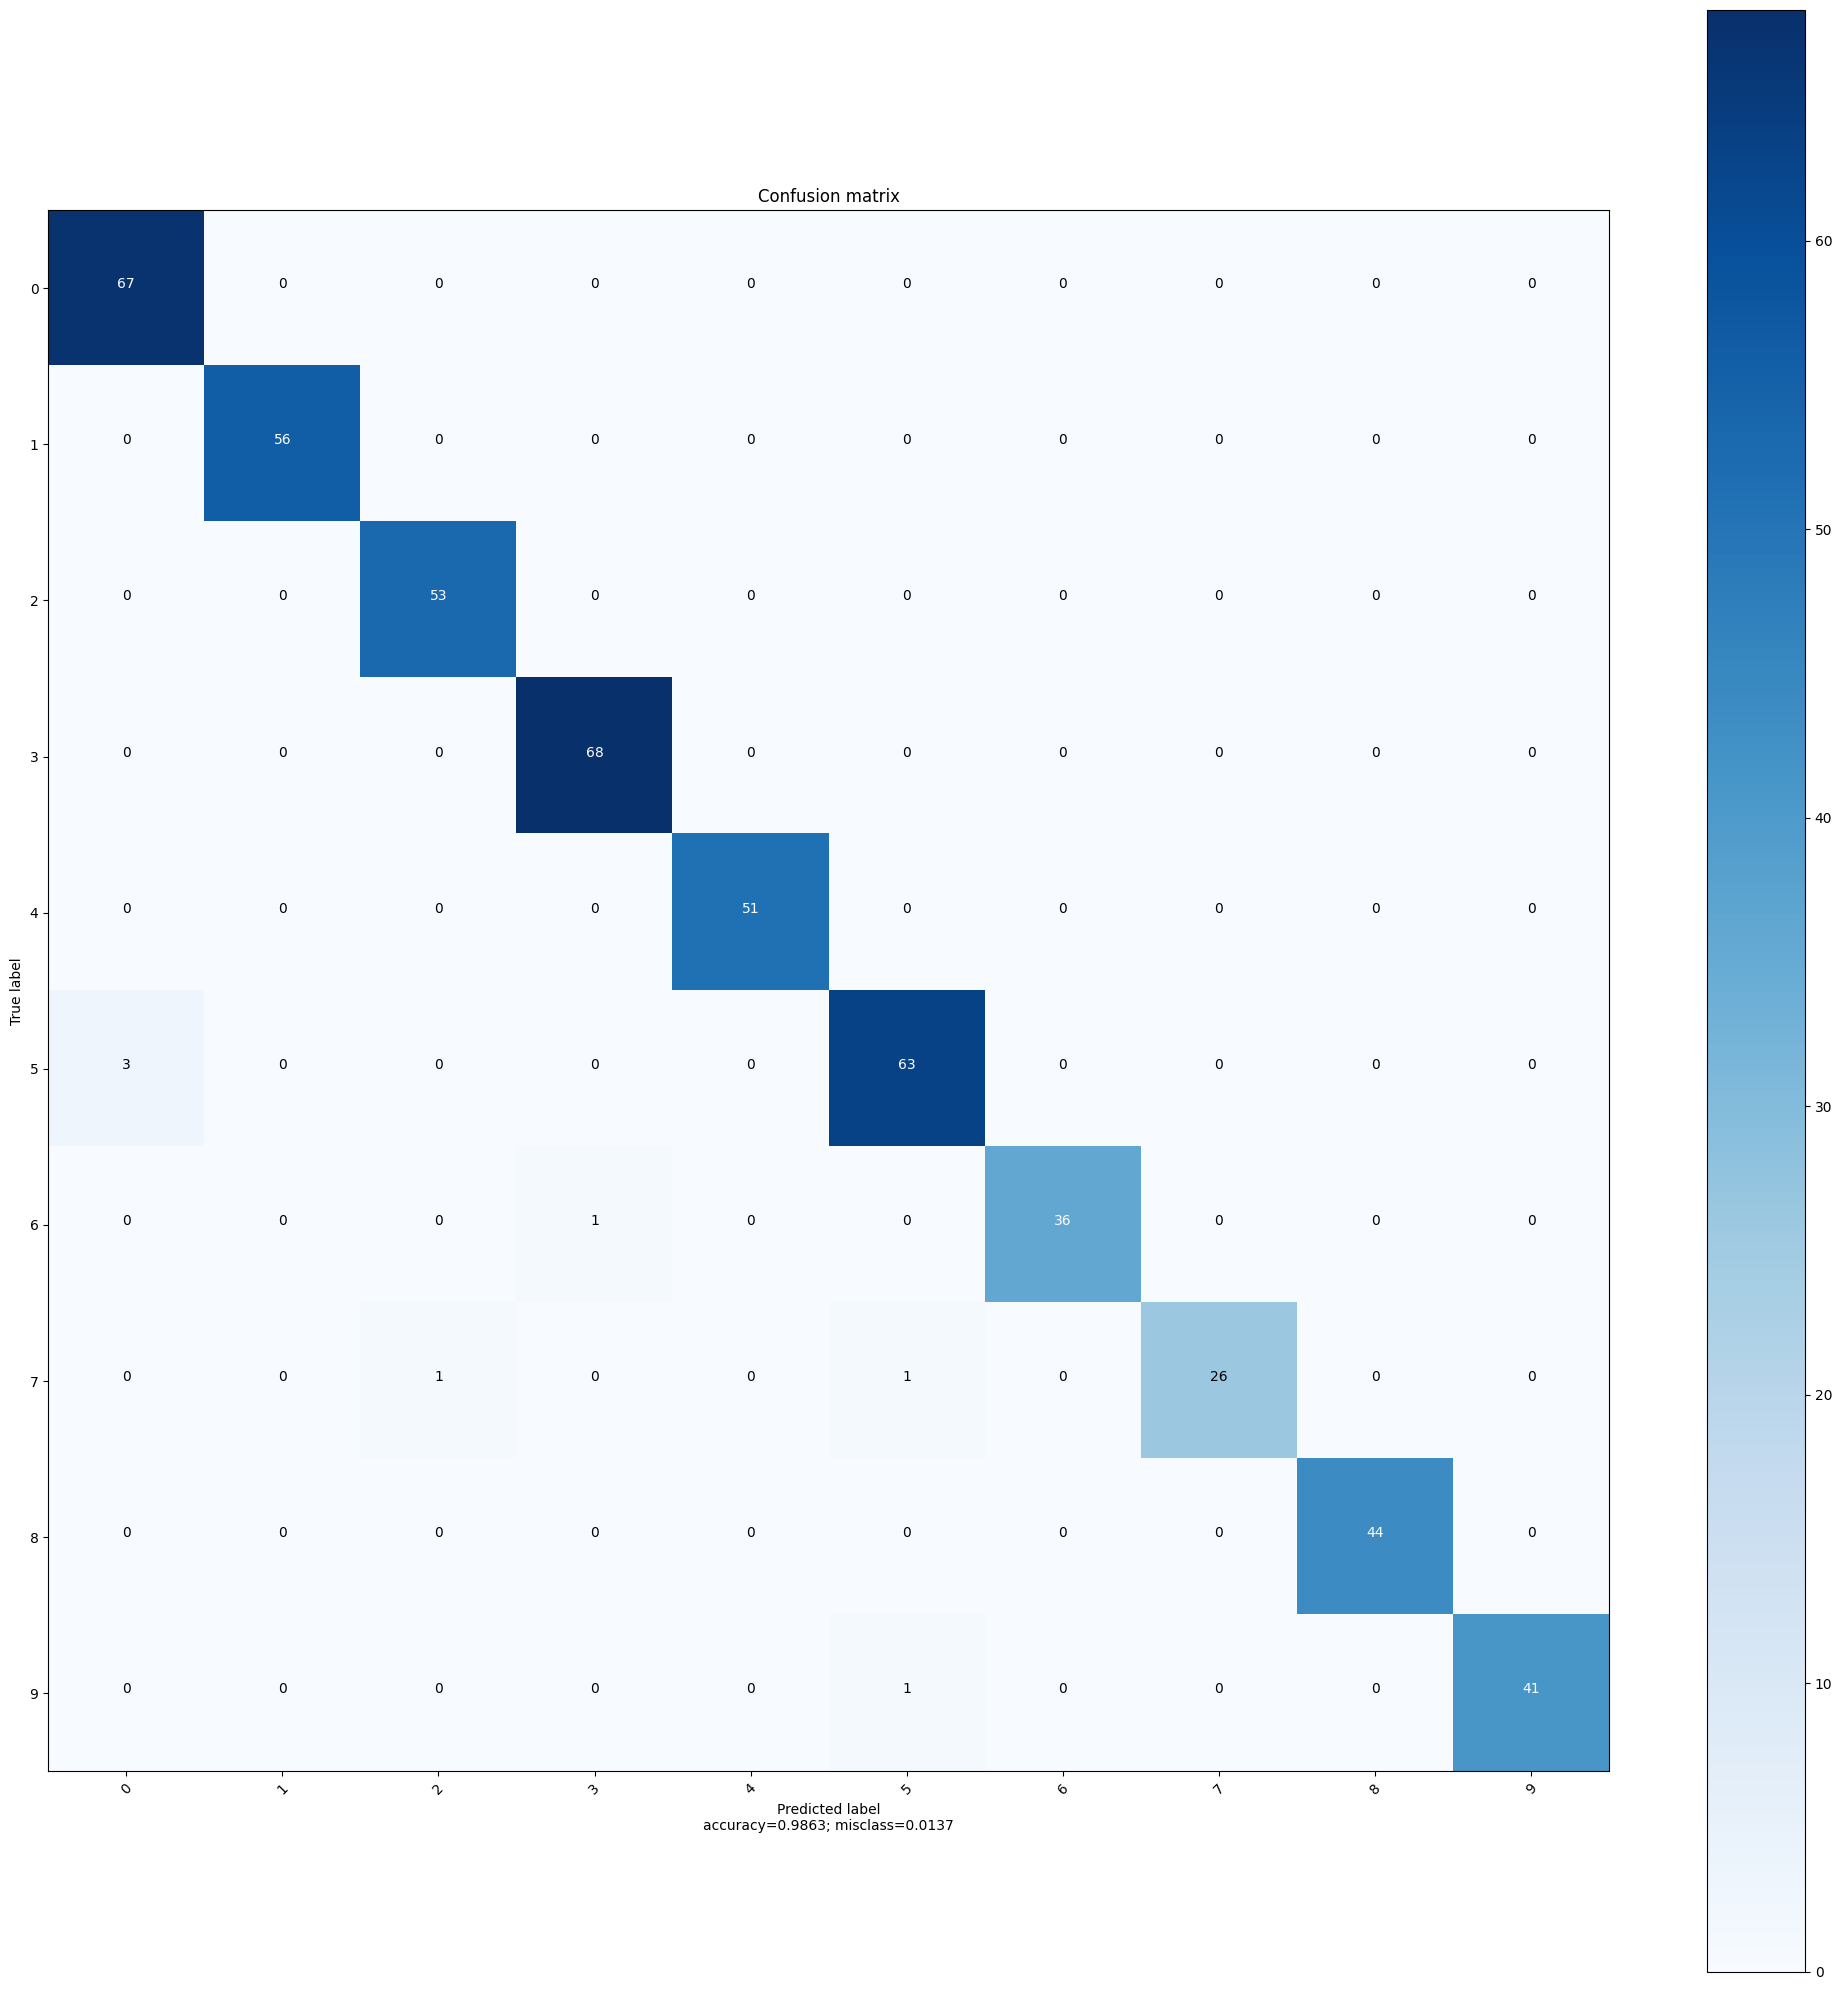

In [18]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import time
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion_matrix.png')


model = load_model('model/keypoint_classifier/keypoint_classifier_new.h5')
pred_labels=[]
start_time = time.time()
pred_probabs = model.predict(X_test)
end_time = time.time()
pred_time = end_time - start_time
avg_pred_time = pred_time / X_test.shape[0]
print('Average prediction time: %fs' % (avg_pred_time))

for pred_probab in pred_probabs:
    pred_labels.append(list(pred_probab).index(max(pred_probab)))

cm = confusion_matrix(y_test, np.array(pred_labels))

classification_report = classification_report(y_test, np.array(pred_labels))
print('\n\nClassification Report')
print('---------------------------')
print(classification_report)
plot_confusion_matrix(cm, range(10), normalize=False)


In [19]:
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmp41x2epux\assets


6808

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


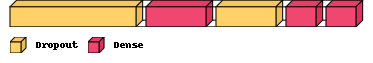

In [21]:
from PIL import ImageFont
import visualkeras
visualkeras.layered_view(model,legend=True,scale_xy=10, scale_z=3, max_z=5000,to_file='model.png')